# Neural Networks for MNIST dataset

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import numpy as np
import pandas as pd 

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Loading MNIST
Here we load the dataset and create data loaders.

In [3]:
train_ds = datasets.MNIST('data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [4]:
batch_size = 32
#batch_size = 5 # for testing
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)

## Looking at Examples

In [5]:
train_dl = iter(train_loader)
x, y = next(train_dl)

In [6]:
print(x.shape, y.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


Looking are images

In [7]:
def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [8]:
# first from torch to numpy
X = x.numpy(); Y = y.numpy()
X.shape

(32, 1, 28, 28)

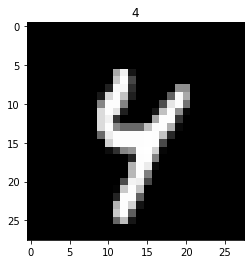

In [9]:
show(X[0][0], Y[0])

In [10]:
print(X[0][0][:4][:4])

[[-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421

## Feed Forward Neural Network

In [11]:
# for the number of neurons in the hidden unit
def get_model(M = 300):
    net = nn.Sequential(nn.Linear(28*28, M),
                        nn.ReLU(),
                        nn.Linear(M, 10))
    return net #.cuda()

In [12]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    model.train()
    for epoch in range(num_epochs):
        sum_loss = 0.0
        total = 0
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = images.view(-1, 28*28) #.cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.item()
                
        train_loss = sum_loss/total
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
    return val_acc, val_loss, train_loss

In [13]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28)  #.cuda()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.item()
        total += labels.size(0)
        correct += pred.eq(labels.data).sum().item()
    return 100 * correct / total, sum_loss/ total

In [14]:
net = get_model()
learning_rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
model_accuracy_loss(net, test_loader)

(13.6, 2.3312927993774415)

In [15]:
val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=2, model=net, optimizer=optimizer)

Epoch [1/2], Loss: 0.3377
Epoch [1/2], Valid Accuracy: 92.1200, Valid Loss: 0.3136
Epoch [2/2], Loss: 0.2624
Epoch [2/2], Valid Accuracy: 93.0300, Valid Loss: 0.2796


## Task1
The sample code contains the code required to train a neural network.
You will train a 2 layers neural network. The hidden layer has M=300
neurons. We are using Relu as the activation of the hidden layer. We
are using softmax after the second layer (F.cross entropy computes
the softwax). Use the training and validation set find a good learning
rate. Report a table of validation accuracy for the following values of
learning rate 1, 0.1, 0.01, 0.001, 0.0001, 0.00001. Interpolate between
the best two values. Train for nb_epoch = 10. (You need to restart the
initial weights by calling the function get model() on every experiment.

In [ ]:
learning_rates = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
validation_accuracy = []

for learning_rate in learning_rates:
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    model_accuracy_loss(net, test_loader)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    validation_accuracy.append(val_acc)

Epoch [1/10], Loss: 64.7685
Epoch [1/10], Valid Accuracy: 10.3400, Valid Loss: 3.2090
Epoch [2/10], Loss: 4.7757
Epoch [2/10], Valid Accuracy: 10.1000, Valid Loss: 4.0415
Epoch [3/10], Loss: 2.8463
Epoch [3/10], Valid Accuracy: 10.3200, Valid Loss: 3.0766
Epoch [4/10], Loss: 2.4071
Epoch [4/10], Valid Accuracy: 9.5800, Valid Loss: 2.9800
Epoch [5/10], Loss: 2.4100
Epoch [5/10], Valid Accuracy: 10.0800, Valid Loss: 3.0571
Epoch [6/10], Loss: 2.4147
Epoch [6/10], Valid Accuracy: 9.8000, Valid Loss: 2.9868
Epoch [7/10], Loss: 2.4082
Epoch [7/10], Valid Accuracy: 10.0800, Valid Loss: 2.9591
Epoch [8/10], Loss: 2.4123
Epoch [8/10], Valid Accuracy: 8.9100, Valid Loss: 3.1645
Epoch [9/10], Loss: 2.4113
Epoch [9/10], Valid Accuracy: 9.8200, Valid Loss: 3.0086
Epoch [10/10], Loss: 2.4087
Epoch [10/10], Valid Accuracy: 10.2800, Valid Loss: 2.9528
Epoch [1/10], Loss: 2.7776
Epoch [1/10], Valid Accuracy: 9.8500, Valid Loss: 2.3078
Epoch [2/10], Loss: 2.3466
Epoch [2/10], Valid Accuracy: 10.1100, V

In [ ]:
pd.DataFrame(data=[learning_rates, validation_accuracy],index=['Learning Rate','Validation Accuracy'])

,0,1,2,3,4,5
Learning Rate,1.00,0.10,0.01,0.001,0.0001,0.00001
Validation Accuracy,10.28,11.37,94.16,97.710,97.7600,93.76000


In [ ]:
learning_rates = np.linspace(0.0001, 0.001, 5)
validation_accuracy = []

for learning_rate in learning_rates:
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    model_accuracy_loss(net, test_loader)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    validation_accuracy.append(val_acc)

Epoch [1/10], Loss: 0.4040
Epoch [1/10], Valid Accuracy: 93.4200, Valid Loss: 0.2271
Epoch [2/10], Loss: 0.1964
Epoch [2/10], Valid Accuracy: 95.5200, Valid Loss: 0.1582
Epoch [3/10], Loss: 0.1428
Epoch [3/10], Valid Accuracy: 96.2400, Valid Loss: 0.1235
Epoch [4/10], Loss: 0.1118
Epoch [4/10], Valid Accuracy: 96.8200, Valid Loss: 0.1071
Epoch [5/10], Loss: 0.0909
Epoch [5/10], Valid Accuracy: 97.2800, Valid Loss: 0.0948
Epoch [6/10], Loss: 0.0758
Epoch [6/10], Valid Accuracy: 97.3500, Valid Loss: 0.0824
Epoch [7/10], Loss: 0.0638
Epoch [7/10], Valid Accuracy: 97.6300, Valid Loss: 0.0773
Epoch [8/10], Loss: 0.0545
Epoch [8/10], Valid Accuracy: 97.5700, Valid Loss: 0.0749
Epoch [9/10], Loss: 0.0464
Epoch [9/10], Valid Accuracy: 97.7500, Valid Loss: 0.0732
Epoch [10/10], Loss: 0.0403
Epoch [10/10], Valid Accuracy: 97.8300, Valid Loss: 0.0659
Epoch [1/10], Loss: 0.2639
Epoch [1/10], Valid Accuracy: 95.7200, Valid Loss: 0.1386
Epoch [2/10], Loss: 0.1094
Epoch [2/10], Valid Accuracy: 97.060

In [ ]:
pd.DataFrame(data=[learning_rates, validation_accuracy],index=['Learning Rate','Validation Accuracy'])

,0,1,2,3,4
Learning Rate,0.0001,0.000325,0.00055,0.000775,0.001
Validation Accuracy,97.8300,98.070000,97.95000,97.850000,97.430


## Task2
Examine how the size of a hidden layer affect the model’s performance.
Use demo code to train the model with hidden layer size parameters
of 10, 50, 100, 300, 1000, 2000. Use learning rate 0.01 and train for
nb_epoch = 10. Report the validation accuracy achieved by each of
these models. Which hidden layer size parameter achieves the best
performance? Are some of these model overfitting? How can you tell
that?

In [ ]:
Ms = [10, 50, 100, 300, 1000, 2000]
validation_accuracy = []

for M in Ms:
    net = get_model(M)
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    model_accuracy_loss(net, test_loader)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    validation_accuracy.append(val_acc)

Epoch [1/10], Loss: 0.6904
Epoch [1/10], Valid Accuracy: 83.6400, Valid Loss: 0.5481
Epoch [2/10], Loss: 0.5740
Epoch [2/10], Valid Accuracy: 83.6500, Valid Loss: 0.5497
Epoch [3/10], Loss: 0.5411
Epoch [3/10], Valid Accuracy: 85.6000, Valid Loss: 0.5034
Epoch [4/10], Loss: 0.5322
Epoch [4/10], Valid Accuracy: 84.7200, Valid Loss: 0.5241
Epoch [5/10], Loss: 0.5236
Epoch [5/10], Valid Accuracy: 84.4000, Valid Loss: 0.5363
Epoch [6/10], Loss: 0.5262
Epoch [6/10], Valid Accuracy: 85.5400, Valid Loss: 0.4991
Epoch [7/10], Loss: 0.5228
Epoch [7/10], Valid Accuracy: 83.9300, Valid Loss: 0.5750
Epoch [8/10], Loss: 0.5208
Epoch [8/10], Valid Accuracy: 85.8000, Valid Loss: 0.5036
Epoch [9/10], Loss: 0.5175
Epoch [9/10], Valid Accuracy: 82.8600, Valid Loss: 0.5355
Epoch [10/10], Loss: 0.5139
Epoch [10/10], Valid Accuracy: 83.5500, Valid Loss: 0.5673
Epoch [1/10], Loss: 0.3464
Epoch [1/10], Valid Accuracy: 93.6700, Valid Loss: 0.2239
Epoch [2/10], Loss: 0.2699
Epoch [2/10], Valid Accuracy: 93.620

Report the validation accuracy achieved by each of these models. Which hidden layer size parameter achieves the best performance? Are some of these model overfitting? How can you tell that?

In [ ]:
pd.DataFrame(data=[Ms, validation_accuracy],index=['M','Validation Accuracy'])

,0,1,2,3,4,5
M,10.00,50.00,100.00,300.00,1000.00,2000.00
Validation Accuracy,83.55,93.93,93.96,94.39,94.42,93.73


For training 10 epoches, M = 1000 reaches the best Validation Accuracy of 94.42. We can notice most of the models overfit: i.e. the validation loss decreases while the validation accuracy increases.

#### Models with L2 regularization
To add L2 regularization use the `weight_decay` argument on the optimizer

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 0.01)

## Task3
Train a neural network that employs L2 weight decay and compare
it with the network without regularization. Train the model with
weight decay parameters 0, 0.0001, 0.001, 0.01, 0.1, 0.3. Set M = 300
and lr = 0.001 and 20 epochs. Report the train loss, validation loss
and validation accuracy.

In [ ]:
weight_decay = [0, 0.0001, 0.001, 0.01, 0.1, 0.3]
validation_accuracy = []
Train_loss = []
Validation_loss = []

for wd in weight_decay:
    net = get_model(300)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = wd)
    model_accuracy_loss(net, test_loader)
    val_acc, train_loss, val_loss = train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
    print(val_acc, train_loss, val_loss)
    validation_accuracy.append(val_acc)
    Train_loss.append(round(train_loss,4))
    Validation_loss.append(round(val_loss,4))

Epoch [1/20], Loss: 0.2010
Epoch [1/20], Valid Accuracy: 96.9400, Valid Loss: 0.1033
Epoch [2/20], Loss: 0.0893
Epoch [2/20], Valid Accuracy: 97.3300, Valid Loss: 0.0891
Epoch [3/20], Loss: 0.0629
Epoch [3/20], Valid Accuracy: 96.9400, Valid Loss: 0.0960
Epoch [4/20], Loss: 0.0479
Epoch [4/20], Valid Accuracy: 97.5500, Valid Loss: 0.0860
Epoch [5/20], Loss: 0.0402
Epoch [5/20], Valid Accuracy: 97.5700, Valid Loss: 0.0819
Epoch [6/20], Loss: 0.0330
Epoch [6/20], Valid Accuracy: 97.9300, Valid Loss: 0.0843
Epoch [7/20], Loss: 0.0275
Epoch [7/20], Valid Accuracy: 97.2400, Valid Loss: 0.1321
Epoch [8/20], Loss: 0.0245
Epoch [8/20], Valid Accuracy: 97.7700, Valid Loss: 0.0972
Epoch [9/20], Loss: 0.0223
Epoch [9/20], Valid Accuracy: 97.6100, Valid Loss: 0.1086
Epoch [10/20], Loss: 0.0226
Epoch [10/20], Valid Accuracy: 97.8200, Valid Loss: 0.1149
Epoch [11/20], Loss: 0.0190
Epoch [11/20], Valid Accuracy: 97.9500, Valid Loss: 0.1078
Epoch [12/20], Loss: 0.0168
Epoch [12/20], Valid Accuracy: 97

In [ ]:
pd.DataFrame(data=[weight_decay, validation_accuracy,Train_loss,Validation_loss],
             index=['Weight Decay ','Validation Accuracy','Train Loss','Validation Loss'])

,0,1,2,3,4,5
Weight Decay,0.0000,0.0001,0.0010,0.0100,0.1000,0.3000
Validation Accuracy,98.1600,97.5600,97.4200,95.9600,89.8200,86.8000
Train Loss,0.1300,0.1000,0.0805,0.1508,0.4452,0.7989
Validation Loss,0.0141,0.0232,0.0629,0.1653,0.4671,0.8155


## Models with Dropout

In [26]:
def get_model_v2(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules)

## Task4
Dropout is a very popular technique in deep learning community that
enforces regularization in the neural network. The basic idea behind
dropout is simple: during the training a selected fraction of neurons
are zeroed out. Explore how the choice of a dropout parameter affect
the performance of the model. Train the model with various dropout parameters ranging for 0 to 1. Take M = 300 and lr = 0.001 and 20
epochs. Report the train loss, validation loss and validation accuracy.
Which parameter value achieves the best performance? Why? Does
the dropout help to increase testing accuracy compared to the model
without a dropout? Compare results with L2 regularization. You can
experiment with lowering the learning rate after 10 epochs.

In [27]:
dropout = [0.1, 0.3, 0.5, 0.7, 0.9]
validation_accuracy = []
Train_loss = []
Validation_loss = []

for p1 in dropout:
    net = get_model_v2(M = 300, p=p1)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    model_accuracy_loss(net, test_loader)
    val_acc, train_loss, val_loss = train_model(train_loader, test_loader,num_epochs=20, model=net, optimizer=optimizer)
    print(val_acc, train_loss, val_loss)
    validation_accuracy.append(val_acc)
    Train_loss.append(round(train_loss,4))
    Validation_loss.append(round(val_loss,4))

Epoch [1/20], Loss: 0.2138
Epoch [1/20], Valid Accuracy: 96.5900, Valid Loss: 0.1089
Epoch [2/20], Loss: 0.0909
Epoch [2/20], Valid Accuracy: 97.1100, Valid Loss: 0.0904
Epoch [3/20], Loss: 0.0637
Epoch [3/20], Valid Accuracy: 97.4100, Valid Loss: 0.0786
Epoch [4/20], Loss: 0.0502
Epoch [4/20], Valid Accuracy: 97.8500, Valid Loss: 0.0750
Epoch [5/20], Loss: 0.0381
Epoch [5/20], Valid Accuracy: 97.6400, Valid Loss: 0.0857
Epoch [6/20], Loss: 0.0342
Epoch [6/20], Valid Accuracy: 97.9300, Valid Loss: 0.0773
Epoch [7/20], Loss: 0.0293
Epoch [7/20], Valid Accuracy: 97.6100, Valid Loss: 0.0968
Epoch [8/20], Loss: 0.0284
Epoch [8/20], Valid Accuracy: 97.8500, Valid Loss: 0.0882
Epoch [9/20], Loss: 0.0223
Epoch [9/20], Valid Accuracy: 97.8500, Valid Loss: 0.0866
Epoch [10/20], Loss: 0.0193
Epoch [10/20], Valid Accuracy: 97.7800, Valid Loss: 0.0967
Epoch [11/20], Loss: 0.0183
Epoch [11/20], Valid Accuracy: 97.9100, Valid Loss: 0.0945
Epoch [12/20], Loss: 0.0194
Epoch [12/20], Valid Accuracy: 97

In [28]:
pd.DataFrame(data=[dropout, validation_accuracy, Train_loss, Validation_loss],
             index=['Dropout rate','Validation Accuracy','Train Loss','Validation Loss'])

,0,1,2,3,4
Dropout rate,0.1000,0.3000,0.5000,0.7000,0.9000
Validation Accuracy,97.8500,97.7900,98.0600,98.2000,98.0100
Train Loss,0.1414,0.1569,0.1309,0.1288,0.1316
Validation Loss,0.0122,0.0116,0.0138,0.0129,0.0132


Which parameter value achieves the best performance? Why? Does the dropout help to increase testing accuracy compared to the model without a dropout?

The dropout rate is 0.7 reaches the best performance. As it reduces the overfit problem. The dropout helps to increase the test accuracy compared to the model with L2 regularization without the dropout.